# Tugas Prapraktikum

Tugas Prapraktikum dikerjakan dengan _dataset_ [Rain in Australia](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package/download?datasetVersionNumber=2). Tanpa meninjau waktu (`date`), prediksi status hujan pada keesokan harinya (`RainTomorrow`). Berikan nilai `1` jika diprediksi hujan pada keesokan harinya, `0` jika tidak.

<br>
Oleh :
<br>
1. 13520135 - Muhammad Alif Putra Yasa
<br>
2. 13520165 - Ghazian Tsabit Alkamil

# 0. Persiapan Data and Pustaka

In [28]:
# Letakkan pustaka di sini.
import numpy as np
import pandas as pd
import scipy.stats as zscore
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [29]:
# Baca data di sini.

data = pd.read_csv("weatherAUS.csv")
df = pd.DataFrame(data)
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


# I. Pemahaman Data
Tujuan dari bagian ini adalah peserta dapat memahami kualitas dari data yang diberikan. Hal yang diliputi adalah sebagai berikut:
1. Ukuran data
2. Statistik dari tiap fitur
3. Pencilan (_outlier_)
4. Korelasi
5. Distribusi 

## I.1 
Carilah:
1. Ukuran dari data (instansi dan fitur)
2. Tipe dari setiap fitur 
3. Banyak nilai unik dari fitur yang bertipe kategorikal
4. Nilai minimum, maksimum, rata-rata, median, dan standar deviasi dari fitur nonkategorikal

### I.1.1

Ukuran Data

In [30]:
df.shape

(145460, 23)

Terdapat **23 fitur** dan **145460 instansi**

### I.1.2

Tipe dari setiap fitur

In [31]:
df.dtypes

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object

### I.1.3

Banyak nilai unik dari fitur yang bertipe kategorikal

In [32]:
# Fitur-fitur kategorikal
categorical_features = [col for col in df.columns if df[col].dtype == "object"]
categorical_features

['Date',
 'Location',
 'WindGustDir',
 'WindDir9am',
 'WindDir3pm',
 'RainToday',
 'RainTomorrow']

In [33]:
print("Jumlah nilai unik:")
for feature in categorical_features:
    print(f" - {feature:<13}: {df[feature].nunique():>4}")

Jumlah nilai unik:
 - Date         : 3436
 - Location     :   49
 - WindGustDir  :   16
 - WindDir9am   :   16
 - WindDir3pm   :   16
 - RainToday    :    2
 - RainTomorrow :    2


### I.1.4

Nilai minimum, maksimum, rata-rata, median, dan standar deviasi dari fitur nonkategorikal

In [34]:
# Fitur non kategorikal
noncategorical_features = [col for col in df.columns if df[col].dtype != "object"]
noncategorical_features

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm']

In [35]:
(
    df[noncategorical_features]
        .describe()
        .loc[["min", "max", "mean", "50%", "std"]]
        .rename(index={'50%': 'median'})
)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
median,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665


## I.2
Carilah:
1. Nilai hilang (_missing_) dari setiap fitur
2. Nilai pencilan (_outlier_) dari setiap fitur

In [36]:
# I.2.1 Nilai hilang (missing) dari setiap fitur 

missing_value = df.isnull().sum()
missing_value = missing_value.to_frame()
missing_value.columns = ['jumlah missing value']
missing_value

,jumlah missing value
Date,0
Location,0
MinTemp,1485
MaxTemp,1261
Rainfall,3261
Evaporation,62790
Sunshine,69835
WindGustDir,10326
WindGustSpeed,10263
WindDir9am,10566


In [37]:
'''
I.2.2 Nilai pencilan (outlier) dari setiap fitur 

Proses pencarian nilai pencilan dari setiap fitur menggunakan metode IQR untuk fitur
yang memiliki tipe data numerical dan menggunakan metode frequency distribution untuk 
fitur yang memiliki tipe data kategorikal.
Data yang dianggap pencilan untuk fitur yang memiliki tipe numerical adalah data yang 
berada di luar rentang Q1 - 1.5*IQR dan Q3 + 1.5*IQR dengan IQR = Q3 - Q1.
Data yang dianggap pencilan untuk fitur yang memiliki tipe kategorikal adalah data yang
frekuensi z-scorenya lebih dari 2.5.

'''

def IQR_outlier(data, col):
    
    # Nilai Q1 dan Q3
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    # Nilai IQR
    IQR = Q3 - Q1
    # Lower bound dan upper bound
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Nilai outlier
    outlier = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    return outlier, lower_bound, upper_bound

# Nilai pencilan dari setiap fitur
outliers_data = pd.DataFrame(columns = ['Fitur', 'Jumlah nilai pencilan', 'Upper bound', 'Lower bound', 'Nilai pencilan'])

for col in df.columns:
    if df[col].dtype == 'float64' or df[col].dtype == 'int64':
        outliers, lower_bound, upper_bound = IQR_outlier(df, col)
        if len(outliers) > 0:
            res = pd.DataFrame({'Fitur':[col], 'Jumlah nilai pencilan':[len(outliers)], 'Upper bound':[upper_bound], 'Lower bound':[lower_bound], 'Nilai pencilan':None})
            outliers_data = pd.concat([outliers_data, res])
        else:
            res = pd.DataFrame({'Fitur':[col], 'Jumlah nilai pencilan':[len(outliers)], 'Upper bound':[upper_bound], 'Lower bound':[lower_bound], 'Nilai pencilan':None})
            outliers_data = pd.concat([outliers_data, res])
    else:
        # Nilai frekuensi dari setiap nilai kategorikal
        freq = df[col].value_counts()
        # Nilai z-score dari setiap nilai kategorikal
        z = zscore.zscore(freq)
        # Nilai pencilan
        outliers = freq[z > 2.5]
        if len(outliers) > 0:
            res = pd.DataFrame({'Fitur':[col], 'Jumlah nilai pencilan':[len(outliers)], 'Upper bound':None, 'Lower bound':[2.5], 'Nilai pencilan':outliers.index.tolist()}, index = [0])
            outliers_data = pd.concat([outliers_data, res])
        else:
            res = pd.DataFrame({'Fitur':[col], 'Jumlah nilai pencilan':[len(outliers)], 'Upper bound':None, 'Lower bound':[2.5], 'Nilai pencilan':None}, index = [0])
            outliers_data = pd.concat([outliers_data, res])
outliers_data = outliers_data.reset_index(drop = True)
outliers_data

# Untuk fitur dengan tipe data numerical, value dari nilai pencilan tidak ditambahkan di data frame, karena nilai tersebut
# terlalu banyak sehingga tidak dapat ditampilkan. Untuk fitur dengan tipe data kategorikal, value dari nilai pencilan terdapat pada kolom
# nilai pencilan.

,Fitur,Jumlah nilai pencilan,Upper bound,Lower bound,Nilai pencilan
0,Date,0,None,2.5,None
1,Location,0,None,2.5,None
2,MinTemp,54,30.85,-6.35,None
3,MaxTemp,489,43.65,2.45,None
4,Rainfall,25578,2.0,-1.2,None
5,Evaporation,1995,14.6,-4.6,None
6,Sunshine,0,19.3,-3.9,None
7,WindGustDir,0,None,2.5,None
8,WindGustSpeed,3092,73.5,5.5,None
9,WindDir9am,1,None,2.5,N


## I.3
Lakukan:
1. Pencarian korelasi antarfitur
2. Visualisasi distribusi setiap fitur (kategorikal dan kontinu)
3. Visualisasi distribusi setiap fitur per target (`RainTomorrow`)

### I.3.1

Pencarian korelasi antarfitur

In [38]:
# I.3 Kode di sini.
df[noncategorical_features].corr()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
MinTemp,1.000000,0.736555,0.103938,0.466993,0.072586,0.177415,0.175064,0.175173,-0.232899,0.006089,-0.450970,-0.461292,0.078754,0.021605,0.901821,0.708906
MaxTemp,0.736555,1.000000,-0.074992,0.587932,0.470156,0.067615,0.014450,0.050300,-0.504110,-0.508855,-0.332061,-0.427167,-0.289370,-0.277921,0.887210,0.984503
Rainfall,0.103938,-0.074992,1.000000,-0.064351,-0.227549,0.133659,0.087338,0.057887,0.224405,0.255755,-0.168154,-0.126534,0.198528,0.172403,0.011192,-0.079657
Evaporation,0.466993,0.587932,-0.064351,1.000000,0.365602,0.203021,0.193084,0.129400,-0.504092,-0.390243,-0.270362,-0.293581,-0.183793,-0.182618,0.545115,0.572893
Sunshine,0.072586,0.470156,-0.227549,0.365602,1.000000,-0.034750,0.005499,0.053834,-0.490819,-0.629130,0.041970,-0.019719,-0.675323,-0.703930,0.291188,0.490501
WindGustSpeed,0.177415,0.067615,0.133659,0.203021,-0.034750,1.000000,0.605303,0.686307,-0.215070,-0.026327,-0.458744,-0.413749,0.071736,0.109168,0.150150,0.032748
WindSpeed9am,0.175064,0.014450,0.087338,0.193084,0.005499,0.605303,1.000000,0.519547,-0.270858,-0.031614,-0.228743,-0.175817,0.025112,0.054639,0.128545,0.004569
WindSpeed3pm,0.175173,0.050300,0.057887,0.129400,0.053834,0.686307,0.519547,1.000000,-0.145525,0.016432,-0.296351,-0.255439,0.053337,0.025396,0.163030,0.027778
Humidity9am,-0.232899,-0.504110,0.224405,-0.504092,-0.490819,-0.215070,-0.270858,-0.145525,1.000000,0.666949,0.139442,0.186858,0.452297,0.357326,-0.471354,-0.498399
Humidity3pm,0.006089,-0.508855,0.255755,-0.390243,-0.629130,-0.026327,-0.031614,0.016432,0.666949,1.000000,-0.027544,0.051997,0.517120,0.523120,-0.221019,-0.557841


### I.3.2

Visualisasi distribusi setiap fitur (kategorikal dan kontinu)

In [39]:
# Ubah kolom tanggal dari string ke Datetime
df_clean_date = df.copy(deep=True)
df_clean_date['Date'] = pd.to_datetime(df_clean_date['Date'])

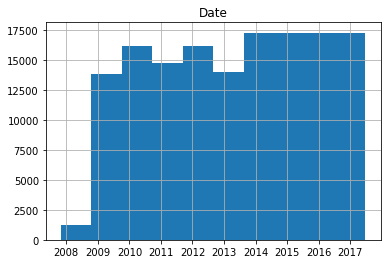

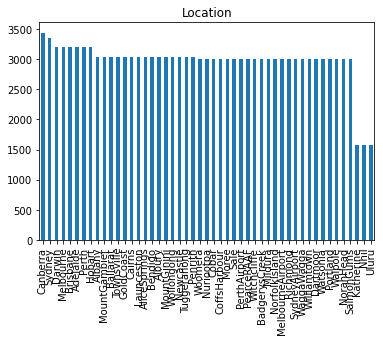

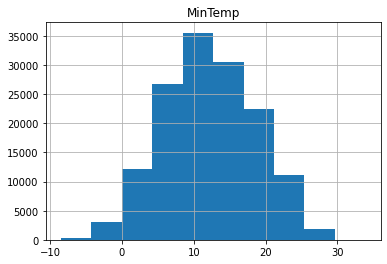

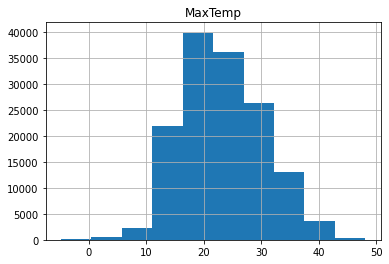

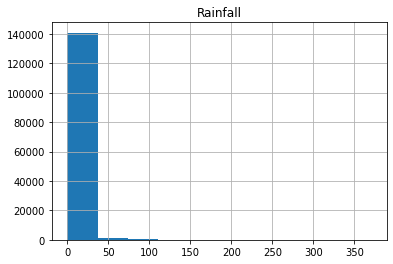

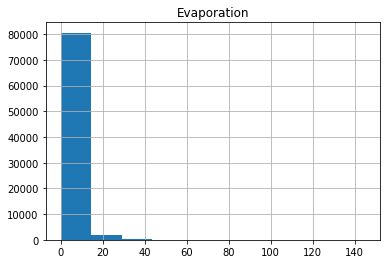

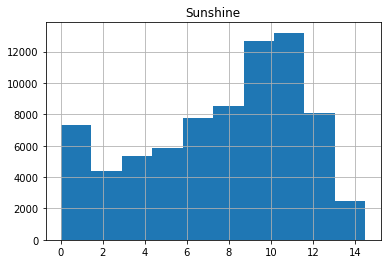

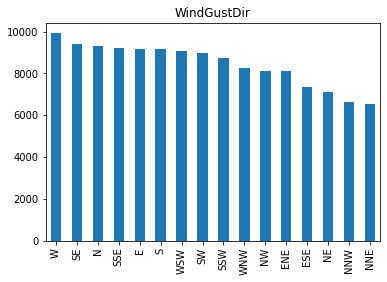

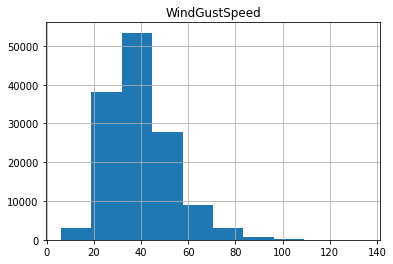

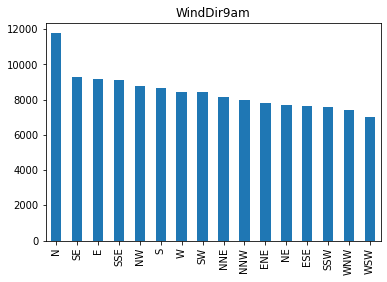

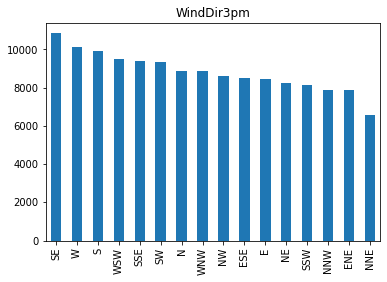

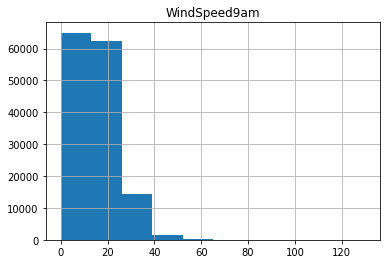

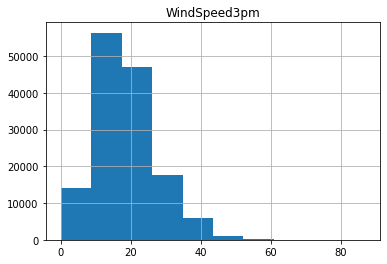

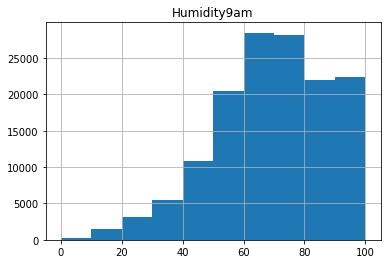

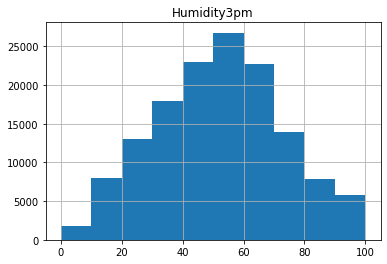

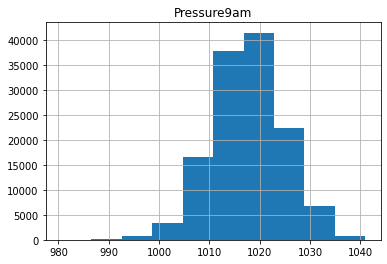

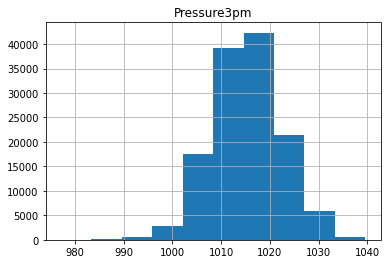

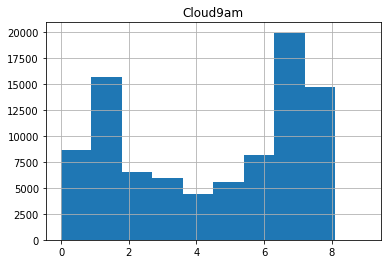

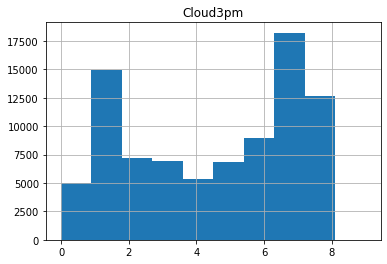

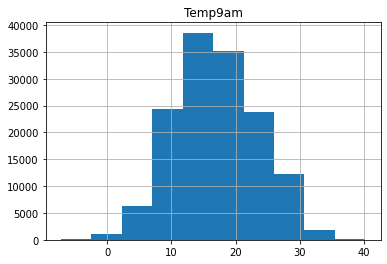

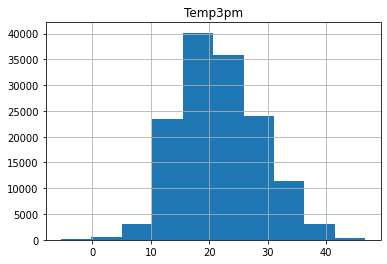

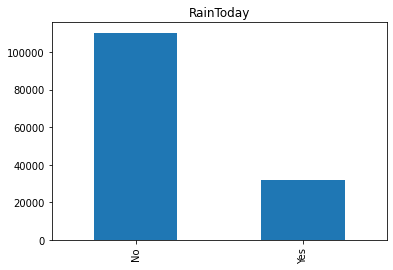

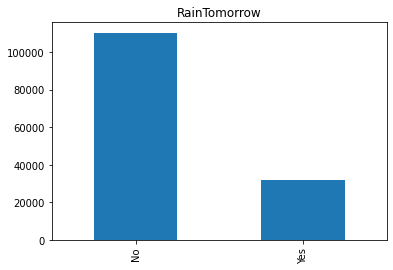

In [40]:
for col in df_clean_date.columns:
    if df_clean_date[col].dtype == 'object':
        df_clean_date[col].value_counts().plot(kind='bar')
    else:
        df_clean_date[col].hist()
    plt.title(col)
    plt.show()

### I.3.3

Visualisasi distribusi setiap fitur per target (`RainTomorrow`)

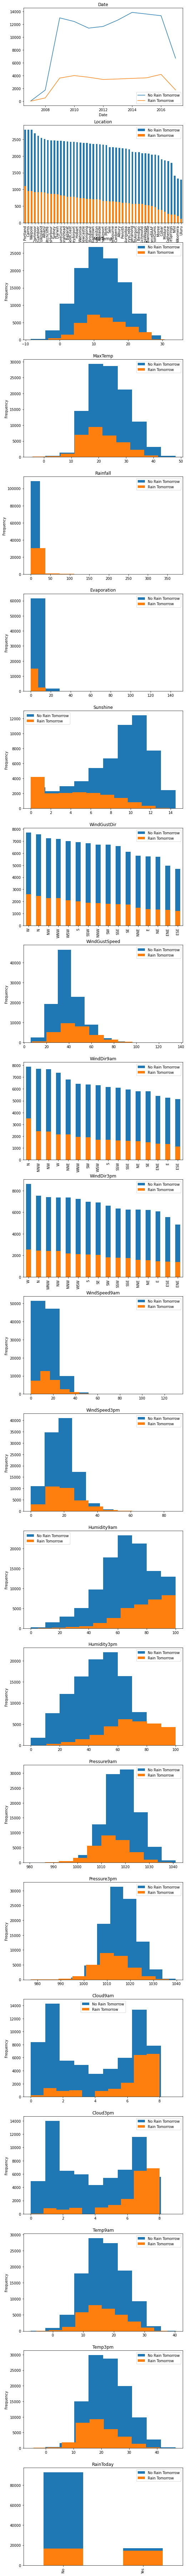

In [41]:
# create subplots
fig, axes = plt.subplots(nrows=len(df_clean_date.columns) - 1, ncols=1, figsize=(8, (len(df_clean_date.columns) - 1) * 6))
# loop over the columns
for i, col in enumerate(df_clean_date.columns):
    if col == 'RainTomorrow':
        continue
    elif df_clean_date[col].dtype == 'object':
        # categorical column - use bar chart
        df_clean_date[df_clean_date['RainTomorrow'] == 'No'][col].value_counts().plot.bar(ax=axes[i], label='No Rain Tomorrow', color='tab:blue')
        df_clean_date[df_clean_date['RainTomorrow'] == 'Yes'][col].value_counts().plot.bar(ax=axes[i], label='Rain Tomorrow', color='tab:orange')
        axes[i].set_title(col)
        axes[i].legend()
    elif df_clean_date[col].dtype == 'datetime64[ns]':
        no_date = df_clean_date[df_clean_date['RainTomorrow'] == 'No'][['Date', 'RainTomorrow']]
        no_date.groupby(no_date["Date"].dt.year).count()['RainTomorrow'].plot(kind='line', label='No Rain Tomorrow', ax=axes[i], legend=True, color='tab:blue')
        yes_date = df_clean_date[df_clean_date['RainTomorrow'] == 'Yes'][['Date', 'RainTomorrow']]
        yes_date.groupby(yes_date["Date"].dt.year).count()['RainTomorrow'].plot(kind='line', label='Rain Tomorrow', ax=axes[i], legend=True, color='tab:orange')
        axes[i].set_title(col)
    else:
        # non-categorical column - use histogram
        df_clean_date[df_clean_date['RainTomorrow'] == 'No'][col].plot.hist(ax=axes[i], label='No Rain Tomorrow', color='tab:blue')
        df_clean_date[df_clean_date['RainTomorrow'] == 'Yes'][col].plot.hist(ax=axes[i], label='Rain Tomorrow', color='tab:orange')
        axes[i].set_title(col)
        axes[i].legend()

# show the plot
plt.show()

## I.4
Lakukanlah analisis lebih lanjut jika diperlukan, kemudian lakukan hal berikut:
1. Penambahan fitur jika memungkinkan
2. Pembuangan fitur yang menurut kalian tidak dibutuhkan
3. Penanganan nilai hilang
4. Transformasi data kategorikal menjadi numerikal (_encoding_)
5. _Scaling_ dengan `MinMaxScaler`

### I.4.1 Penambahan fitur jika memungkinkan

Dari hasil analisis data, tidak diperlukan penambahan fitur baru. Data yang ada 
sudah cukup untuk melakukan prediksi status hujan pada keesokan harinya.

In [42]:
'''
I.4.2 Pembuangan fitur yang tidak diperlukan

Dari hasil analisis data, fitur yang tidak diperlukan adalah fitur 'Date' dan 'Location'.
'''

# Pembuangan fitur yang tidak diperlukan
df.drop(['Date', 'Location'], axis = 1, inplace = True)
df.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [43]:
'''
I.4.3 Penanganan nilai hilang (missing)

Dari hasil analisis data penangan terhadap nilai hilang dibagi menjadi 2 bagian, yaitu
penanganan nilai hilang pada fitur yang memiliki tipe data numerical dan penanganan
nilai hilang pada fitur yang memiliki tipe data kategorikal. Untuk penanganan nilai
hilang pada fitur yang memiliki tipe data numerical, nilai hilang diisi dengan nilai
rata rata dari fitur tersebut. Untuk penanganan nilai hilang pada fitur yang memiliki tipe
data kategorikal, nilai hilang diisi dengan nilai modus dari fitur tersebut.
'''

# Penanganan nilai hilang pada fitur yang memiliki tipe data numerical
for col in df.columns:
    if df[col].dtype == 'float64' or df[col].dtype == 'int64':
        df[col].fillna(df[col].mean(), inplace = True)
    else:
        df[col].fillna(df[col].mode()[0], inplace = True)

In [44]:
# I.4.4 Transformasi data kategorikal menjadi numerikal (encoding)

encoder = LabelEncoder()
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = encoder.fit_transform(df[col])
df.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,13.4,22.9,0.6,5.468232,7.611178,13,44.0,13,14,20.0,...,71.0,22.0,1007.7,1007.1,8.000000,4.50993,16.9,21.8,0,0
1,7.4,25.1,0.0,5.468232,7.611178,14,44.0,6,15,4.0,...,44.0,25.0,1010.6,1007.8,4.447461,4.50993,17.2,24.3,0,0
2,12.9,25.7,0.0,5.468232,7.611178,15,46.0,13,15,19.0,...,38.0,30.0,1007.6,1008.7,4.447461,2.00000,21.0,23.2,0,0
3,9.2,28.0,0.0,5.468232,7.611178,4,24.0,9,0,11.0,...,45.0,16.0,1017.6,1012.8,4.447461,4.50993,18.1,26.5,0,0
4,17.5,32.3,1.0,5.468232,7.611178,13,41.0,1,7,7.0,...,82.0,33.0,1010.8,1006.0,7.000000,8.00000,17.8,29.7,0,0


In [45]:
# I.4.5 Scaling dengan metode MinMaxScaler

scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df, columns = df.columns)
scaled_df.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,0.516509,0.523629,0.001617,0.037712,0.524909,0.866667,0.294574,0.866667,0.933333,0.153846,...,0.71,0.22,0.449587,0.4800,0.888889,0.501103,0.508439,0.522073,0.0,0.0
1,0.375000,0.565217,0.000000,0.037712,0.524909,0.933333,0.294574,0.400000,1.000000,0.030769,...,0.44,0.25,0.497521,0.4912,0.494162,0.501103,0.514768,0.570058,0.0,0.0
2,0.504717,0.576560,0.000000,0.037712,0.524909,1.000000,0.310078,0.866667,1.000000,0.146154,...,0.38,0.30,0.447934,0.5056,0.494162,0.222222,0.594937,0.548944,0.0,0.0
3,0.417453,0.620038,0.000000,0.037712,0.524909,0.266667,0.139535,0.600000,0.000000,0.084615,...,0.45,0.16,0.613223,0.5712,0.494162,0.501103,0.533755,0.612284,0.0,0.0
4,0.613208,0.701323,0.002695,0.037712,0.524909,0.866667,0.271318,0.066667,0.466667,0.053846,...,0.82,0.33,0.500826,0.4624,0.777778,0.888889,0.527426,0.673704,0.0,0.0


# II. Desain Eksperimen
Tujuan dari bagian ini adalah peserta dapat memahami cara melakukan eksperimen mencari metode terbaik dengan benar. Hal yang diliputi adalah sebagai berikut:
1. Pembuatan model
2. Proses validasi
3. _Hyperparameter tuning_

## II.1
Tentukanlah metrik yang akan digunakan pada eksperimen kali ini. Metrik yang dapat lebih dari satu jenis.

1. Accuracy
2. Recall
3. F1 Score
4. Precisision

## II.2 
Bagi data dengan perbandingan 0,8 untuk data latih dan 0,2 untuk data validasi.

In [46]:
# II.2 Kode di sini

x = df[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday']]
y = df['RainTomorrow']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2,  train_size=0.8, random_state = 42)

## II.3
Lakukan hal berikut:
1. Prediksi dengan menggunakan model _logistic regression_ sebagai _baseline_.
2. Tampilkan evaluasi dari model yang dibangun dari metrik yang ditentukan pada II.1
3. Tampilkan _confusion matrix_.

In [47]:
# II.3.1  Prediksi dengan menggunakan model logistic regression sebagai baseline

lr = LogisticRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

In [48]:
# II.3.2  Evaluasi dari model logistic regression

print("Evaluasi dari model logistic regression dengan metrics yang sudah ditentukan sebelumnya: ")
print(classification_report(y_test, y_pred))
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))

Evaluasi dari model logistic regression dengan metrics yang sudah ditentukan sebelumnya: 
              precision    recall  f1-score   support

           0       0.86      0.95      0.90     22672
           1       0.71      0.45      0.55      6420

    accuracy                           0.84     29092
   macro avg       0.79      0.70      0.73     29092
weighted avg       0.83      0.84      0.82     29092

Accuracy:  0.8387872954764196
Precision:  0.7128444881889764
Recall:  0.4512461059190031
F1 Score:  0.552651659671881


In [49]:
# II.3.3  Confusion matrix dari model logistic regression

print("Confusion matrix dari model logistic regression: ")
print(pd.DataFrame(confusion_matrix(y_test, y_pred), columns = ['Predicted No', 'Predicted Yes'], index = ['Actual No', 'Actual Yes']))

Confusion matrix dari model logistic regression: 
            Predicted No  Predicted Yes
Actual No          21505           1167
Actual Yes          3523           2897


## II.4 
Lakukanlah:
1. Pembelajaran dengan model lain
2. _Hyperparameter tuning_ untuk model yang dipakai dengan menggunakan _grid search_ (perhatikan _random factor_ pada beberapa algoritma model)
3. Validasi dengan _cross validation_


In [50]:
# Target yang kosong
df['RainTomorrow'].isna().sum()

0

In [51]:
# II.4 Kode di sini.
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import pandas as pd

# Ada yang kosong di Target, jadi di Drop aja
df_dropped = df.dropna(subset=['RainTomorrow'])
X = df_dropped.drop(['RainTomorrow'], axis=1)
y = df_dropped['RainTomorrow']

# Tanganin yang kosong dengan masukin mode
# Terus di onehot encode
categorical_features = [col for col in X.columns if X[col].dtype == "object"]
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Tanganin yang kosong dengan masukin mean
numeric_features = [col for col in X.columns if X[col].dtype != "object"]
numeric_transformer = SimpleImputer(strategy='mean')

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)
    ]
)

# Create an instance of the DecisionTreeClassifier class with the preprocessor
dt = DecisionTreeClassifier(random_state=42)

dt_params = {
    'max_depth': [5, 10, 15, 20],
    'criterion': ['gini', 'entropy', 'log_loss']
}

# Fit the preprocessor on the training data and transform the training and testing data
X_preprocessed = preprocessor.fit_transform(X)

scorers = ['accuracy', 'precision', 'recall', 'f1']

for scorer in scorers:
  grid_search = GridSearchCV(dt, param_grid=dt_params, cv=5, scoring=scorer, n_jobs=-1)
  grid_search.fit(X_preprocessed, y)
  print(f"Grid Search for metric {scorer}")
  print("Best hyperparameters:", grid_search.best_params_)
  print("Best score:", grid_search.best_score_)

Grid Search for metric accuracy
Best hyperparameters: {'criterion': 'entropy', 'max_depth': 5}
Best score: 0.8353430496356387
Grid Search for metric precision
Best hyperparameters: {'criterion': 'gini', 'max_depth': 5}
Best score: 0.725360780509838
Grid Search for metric recall
Best hyperparameters: {'criterion': 'gini', 'max_depth': 20}
Best score: 0.5037810957758261
Grid Search for metric f1
Best hyperparameters: {'criterion': 'entropy', 'max_depth': 10}
Best score: 0.5470329876467206


# III. Improvement
Pada bagian ini, kalian diharapkan dapat:
1. melakukan pelatihan dengan data hasil _oversampling_ / _undersampling_, disertai dengan validasi yang benar; serta
2. menerapkan beberapa metode untuk menggabungkan beberapa model.

Kedua hal ini adalah contoh metode untuk meningkatkan kinerja dari model.

## III.1
Lakukanlah:
1. _Oversampling_ pada kelas minoritas pada data latih
2. _Undersampling_ pada kelas mayoritas pada data latih

Pada setiap tahap, latih dengan model *baseline* (II.3), dan validasi dengan data validasi. Data latih dan validasi adalah data yang disusun pada bagian II.2.

In [52]:
# III.1.1 Oversampling pada kelas minoritas pada data latih

over_sampler = RandomOverSampler(sampling_strategy="not majority", random_state = 42)
over_x_train, over_y_train = over_sampler.fit_resample(x_train, y_train)

lr.fit(over_x_train, over_y_train)
over_y_pred = lr.predict(x_test)

print("Evaluasi dari baseline model dengan oversampling: ")
print(classification_report(y_test, over_y_pred))
print('Accuracy: ', accuracy_score(y_test, over_y_pred))
print('Precision: ', precision_score(y_test, over_y_pred))
print('Recall: ', recall_score(y_test, over_y_pred))
print('F1 Score: ', f1_score(y_test, over_y_pred))

crossval_score = cross_val_score(lr, x_train, y_train.values.ravel(), cv=5)
print("Cross validation score: ", crossval_score)

Evaluasi dari baseline model dengan oversampling: 
              precision    recall  f1-score   support

           0       0.92      0.79      0.85     22672
           1       0.51      0.75      0.60      6420

    accuracy                           0.78     29092
   macro avg       0.71      0.77      0.73     29092
weighted avg       0.83      0.78      0.80     29092

Accuracy:  0.7826206517255603
Precision:  0.5050135784416127
Recall:  0.7531152647975078
F1 Score:  0.6046017256471177
Cross validation score:  [0.84368824 0.83651285 0.83857523 0.83929876 0.83916985]


In [53]:
# III.1.2 Undersampling pada kelas mayoritas pada data latih

under_sampler = RandomUnderSampler(sampling_strategy=1, random_state = 42)
under_x_train, under_y_train = under_sampler.fit_resample(x_train, y_train)

lr.fit(under_x_train, under_y_train)
under_y_pred = lr.predict(x_test)

print("Evaluasi dari baseline model dengan undersampling: ")
print(classification_report(y_test, under_y_pred))
print('Accuracy: ', accuracy_score(y_test, under_y_pred))
print('Precision: ', precision_score(y_test, under_y_pred))
print('Recall: ', recall_score(y_test, under_y_pred))
print('F1 Score: ', f1_score(y_test, under_y_pred))

crossval_score = cross_val_score(lr, x_train, y_train.values.ravel(), cv=5)
print("Cross validation score: ", crossval_score)

Evaluasi dari baseline model dengan undersampling: 
              precision    recall  f1-score   support

           0       0.92      0.79      0.85     22672
           1       0.50      0.76      0.60      6420

    accuracy                           0.78     29092
   macro avg       0.71      0.77      0.72     29092
weighted avg       0.83      0.78      0.79     29092

Accuracy:  0.7792520280489482
Precision:  0.4998969497114592
Recall:  0.755607476635514
F1 Score:  0.601711734061027
Cross validation score:  [0.84368824 0.83651285 0.83857523 0.83929876 0.83916985]


## III.2
Lakukanlah:
1. Eksplorasi _soft voting_, _hard voting_, dan _stacking_.
2. Buatlah model _logistic regression_ dan SVM.
3. Lakukanlah _soft voting_ dari model-model yang dibangun pada poin 2.
4. Lakukan _hard voting_ dari model-model yang dibangun pada poin 2.
5. Lakukanlah _stacking_ dengan _final classifier_ adalah _logistic regression_ dari model-model yang dibangun pada poin 2.
6. Lakukan validasi dengan metrics yang telah ditentukan untuk poin 3, 4, dan 5.

(Tuliskan hasil eksplorasi III.2 poin 1 di sini.)

In [54]:
# III.2 Kode di sini.
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier, StackingClassifier

lr = LogisticRegression(random_state=42)
# SVC kelamaan, jadinya max_iter dikurangi
svm = SVC(random_state=42, max_iter=100, probability=True)

soft_vote_clf = VotingClassifier(estimators=[('lr', lr), ('svm', svm)], voting='soft')
soft_vote_clf.fit(x_train, y_train)
softvote_prediction = soft_vote_clf.predict(x_test)

print("Hasil Soft Voting")
print(classification_report(y_test, softvote_prediction))
print(f"Precision: {precision_score(y_test, softvote_prediction)}")
print(f"Recall   : {recall_score(y_test, softvote_prediction)}")
print(f"F1-score : {f1_score(y_test, softvote_prediction)}")
print(f"Accuracy : {accuracy_score(y_test, softvote_prediction)}")

crossval_score = cross_val_score(soft_vote_clf, x_train, y_train.values.ravel(), cv=5)
print(f"Cross validation score: {crossval_score}")

hard_vote_clf = VotingClassifier(estimators=[('lr', lr), ('svm', svm)], voting='hard')
hard_vote_clf.fit(x_train, y_train)
hardvote_prediction = soft_vote_clf.predict(x_test)

print("Hasil Hard Voting")
print(classification_report(y_test, hardvote_prediction))
print(f"Precision: {precision_score(y_test, hardvote_prediction)}")
print(f"Recall   : {recall_score(y_test, hardvote_prediction)}")
print(f"F1-score : {f1_score(y_test, hardvote_prediction)}")
print(f"Accuracy : {accuracy_score(y_test, hardvote_prediction)}")

crossval_score = cross_val_score(hard_vote_clf, x_train, y_train.values.ravel(), cv=5)
print(f"Cross validation score: {crossval_score}")

stacking_clf = StackingClassifier(estimators=[('lr', lr), ('svm', svm)], final_estimator=LogisticRegression())
stacking_clf.fit(x_train, y_train)
stacking_prediction = stacking_clf.predict(x_test)

print("Hasil Stacking")
print(classification_report(y_test, stacking_prediction))
print(f"Precision: {precision_score(y_test, stacking_prediction)}")
print(f"Recall   : {recall_score(y_test, stacking_prediction)}")
print(f"F1-score : {f1_score(y_test, stacking_prediction)}")
print(f"Accuracy : {accuracy_score(y_test, stacking_prediction)}")

crossval_score = cross_val_score(stacking_clf, x_train, y_train.values.ravel(), cv=5)
print(f"Cross validation score: {crossval_score}")

Hasil Soft Voting
              precision    recall  f1-score   support

           0       0.82      0.99      0.89     22672
           1       0.85      0.21      0.34      6420

    accuracy                           0.82     29092
   macro avg       0.83      0.60      0.62     29092
weighted avg       0.82      0.82      0.77     29092

Precision: 0.85375
Recall   : 0.21277258566978194
F1-score : 0.34064837905236905
Accuracy : 0.8182318163068885
Cross validation score: [0.83543869 0.82443929 0.82413852 0.82297082 0.83809565]
Hasil Hard Voting
              precision    recall  f1-score   support

           0       0.82      0.99      0.89     22672
           1       0.85      0.21      0.34      6420

    accuracy                           0.82     29092
   macro avg       0.83      0.60      0.62     29092
weighted avg       0.82      0.82      0.77     29092

Precision: 0.85375
Recall   : 0.21277258566978194
F1-score : 0.34064837905236905
Accuracy : 0.8182318163068885
Cross v

# IV. Analisis
Bandingkan hasil dari hal-hal berikut:

1. Model _baseline_ (II.3)
2. Model lain (II.4)
3. Hasil _undersampling_
4. Hasil _oversampling_
5. Hasil _soft voting_
6. Hasil _hard voting_
7. Hasil _stacking_

### Model Baseline vs Model lain

- Model baseline
    - Precision Score : 0.7128444881889764
    - Recall Score : 0.4512461059190031
    - F1 Score : 0.552651659671881
    - Accuracy Score : 0.8387872954764196

- Model lain
    - Decision Tree Learning
        - Precision Score : 0.725360780509838
        - Recall Score : 0.5037810957758261
        - F1 Score : 0.5470329876467206
        - Accuracy Score : 0.8353430496356387

Pembelajaran dataset dengan menggunakan model Decision Tree Learning yang sudah di-tune hyperparameternya menghasilkan nilai precision dan recall yang lebih baik, tetapi untuk nilai f1 dan accuracy model logistic regression memberikan nilai yang lebih tinggi daripada
model Decistion Tree Learning. Oleh karena itu, model Decision Tree Learning yang sudah di-tune hyperparameternya lebih baik jika dibandingkan dengan logistic regression. 

### Oversampling vs Undersampling

- Oversampling
    - Precision Score : 0.5050135784416127
    - Recall Score : 0.7531152647975078
    - F1 Score : 0.6046017256471177
    - Accuracy Score : 0.7826206517255603

- Undersampling
    - Precision Score : 0.4998969497114592
    - Recall Score : 0.755607476635514
    - F1 Score : 0.601711734061027
    - Accuracy Score : 0.7792520280489482

Pembelajaran dataset dengan menggunakan strategi improvement Oversampling menghasilkan nilai precision dan f1 yang lebih tinggi, tetapi untuk nilai recall dan accuracy strategi improvement Undersampling menghasilkan nilai yang lebih tinggi. Namun, secara keseluruhan baik strategi Oversampling dan Undersampling menghasilkan nilai yang kurang lebih sama.

### Soft Voting vs Hard Voting vs Stacking

- Soft Voting
    - Precision Score : 0.85375
    - Recall Score : 0.21277258566978194
    - F1 Score : 0.34064837905236905
    - Accuracy Score : 0.8182318163068885

- Hard Voting
    - Precision Score : 0.8540100250626567
    - Recall Score : 0.21230529595015576
    - F1 Score : 0.34006986027944114
    - Accuracy Score : 0.8181630688849169

- Stacking
    - Precision Score : 0.7144638403990025
    - Recall Score : 0.4462616822429907
    - F1 Score : 0.5493767976989454
    - Accuracy Score : 0.8384435583665613

